In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
embedding_path = "../../data/embeddings/bulk_embeddings.npy"
sample_ids_path = "../../data/processed/processed_bulk.csv"

# Load data
embeddings = np.load(embedding_path)
sample_ids = pd.read_csv(sample_ids_path)

# Check shape match
print("Embeddings shape:", embeddings.shape)
print("Sample IDs shape:", sample_ids.shape)
assert embeddings.shape[0] == sample_ids.shape[0], "Mismatch in sample count!"


Embeddings shape: (1431, 3072)
Sample IDs shape: (1431, 19266)


In [2]:
from sklearn.decomposition import PCA

SELECTED_PCS = 30

pca = PCA(n_components=SELECTED_PCS, random_state=42)
pca_transformed = pca.fit_transform(embeddings)

pcs_df = pd.DataFrame(pca_transformed, columns=[f"SCF_PC{i+1}" for i in range(SELECTED_PCS)])
pcs_df["SANGER_MODEL_ID"] = sample_ids["SANGER_MODEL_ID"]

# Save to Parquet
#pcs_df.to_parquet(f"scfoundation_bulk_pca_top{SELECTED_PCS}.parquet", index=False)
print(f"✅ Saved top {SELECTED_PCS} PCs to scfoundation_bulk_pca_top{SELECTED_PCS}.parquet")


✅ Saved top 30 PCs to scfoundation_bulk_pca_top30.parquet


In [3]:
# Load tissue dummies
tissue_df = pd.read_csv("../02_feature_engineering/feature_engineering/processed_tissue_dummies.csv")

# After merging PCA + tissue:
merged_df = pd.merge(pcs_df, tissue_df, on="SANGER_MODEL_ID", how="inner")

# Ensure one row per cell line
dedup_df = merged_df.drop_duplicates(subset="SANGER_MODEL_ID").reset_index(drop=True)
print(f"✅ Deduplicated shape: {dedup_df.shape}")

# Define features (PCs) and target (tissue class from one-hot)
pca_cols = [col for col in dedup_df.columns if col.startswith("SCF_PC")]
tissue_cols = [col for col in dedup_df.columns if col.startswith("Tissue_")]

# Filter for exactly one tissue label per row
valid_mask = merged_df[tissue_cols].sum(axis=1) == 1
filtered_df = merged_df[valid_mask].reset_index(drop=True)

print(f"✅ Filtered down to {filtered_df.shape[0]} valid rows for training.")



✅ Deduplicated shape: (1431, 46)
✅ Filtered down to 1431 valid rows for training.


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Features and labels
X = filtered_df[pca_cols]
y = filtered_df[tissue_cols].idxmax(axis=1)

# Train + evaluate
clf = LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced')
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

print(f"🎯 Tissue classification accuracy from PCs: {scores.mean():.2f} ± {scores.std():.2f}")


🎯 Tissue classification accuracy from PCs: 0.52 ± 0.03


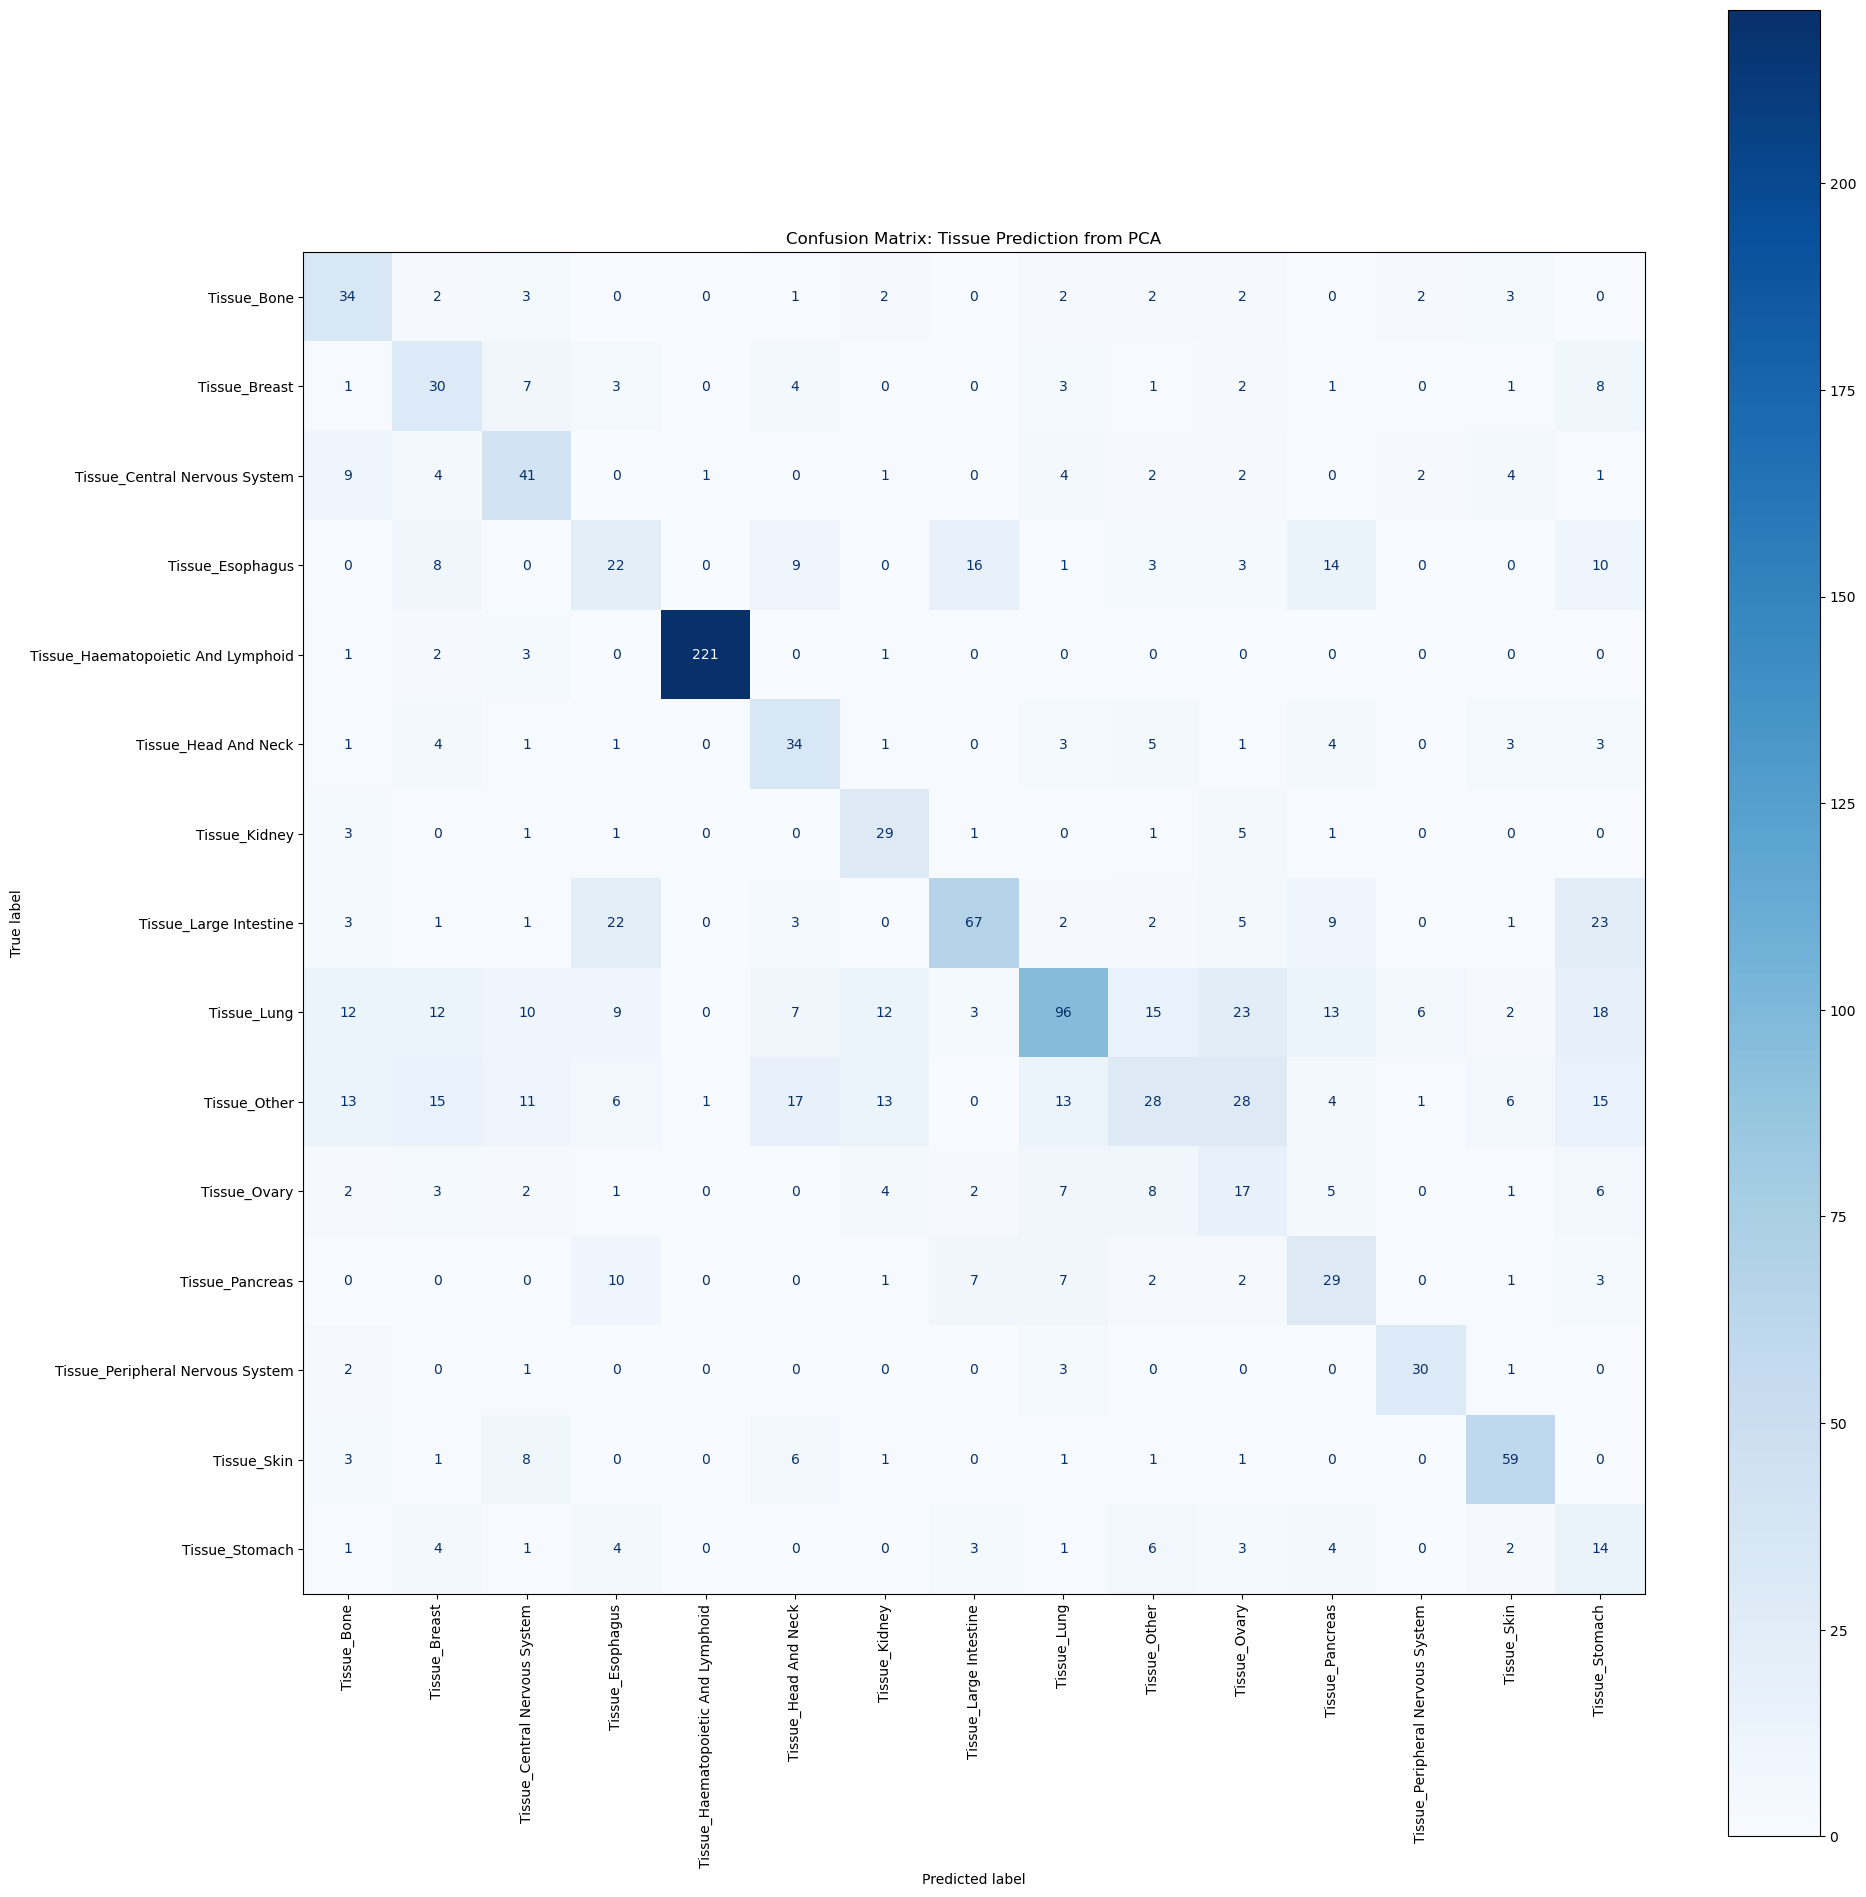

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict all samples using cross-validation
y_pred = cross_val_predict(clf, X, y, cv=5)

# Build confusion matrix
cm = confusion_matrix(y, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))

# Create larger figure and plot inside it
fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix: Tissue Prediction from PCA")
plt.tight_layout()
plt.show()


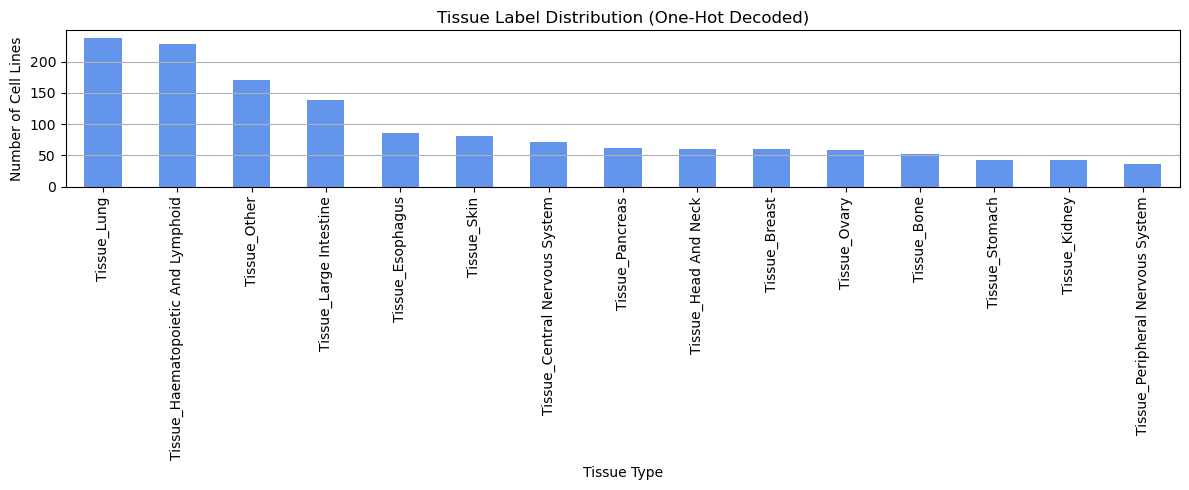

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot frequency of each tissue label
y.value_counts().plot(kind="bar", figsize=(12, 5), color="cornflowerblue")
plt.title("Tissue Label Distribution (One-Hot Decoded)")
plt.xlabel("Tissue Type")
plt.ylabel("Number of Cell Lines")
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
